<a href="https://colab.research.google.com/github/Saif-Shines/pk-cookbook/blob/next/product/101_portkey_gateway_configs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 101 on Portkey's Gateway Configs

You are likely familiar with how to make an API call to GPT4 for chat completions. However, did you know you can **set up** automatic retries for requests that might fail on OpenAI’s end using Portkey?

The Portkey AI gateway provides several useful features that you can use to enhance your requests. In this cookbook, we will start by making an API call to LLM and explore how Gateway Configs can be utilized to optimize these API calls.![gateway-config-builder.png](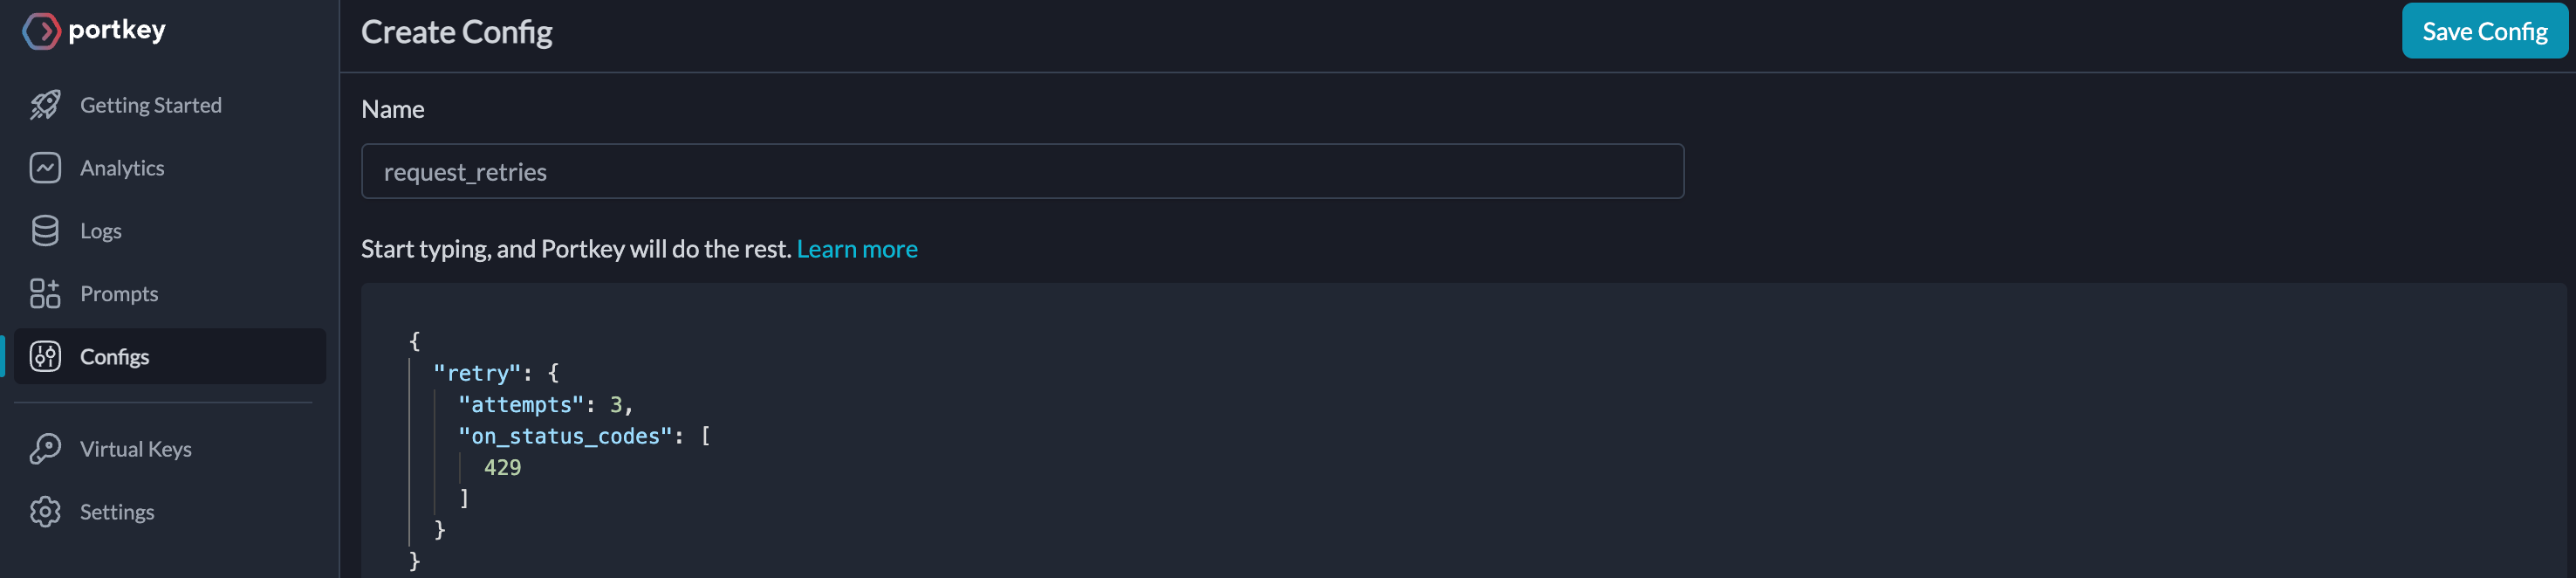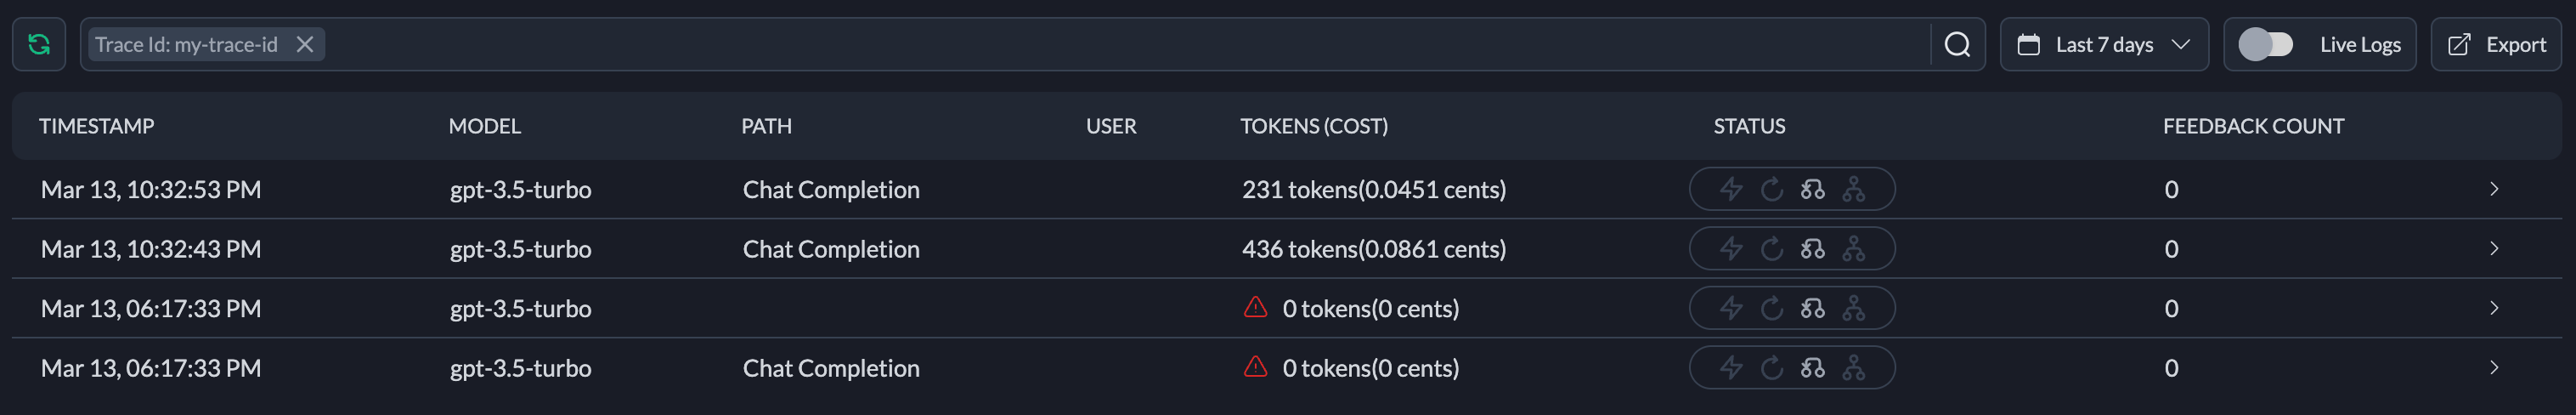)

## 1. API calls to LLMs with Portkey

Consider a typical API call to GPT4 to get chat completions using OpenAI SDK. It takes `messages` and `model` arguments to get us a response. If you have tried one before, the following code snippet should look familiar. That’s because Portkey Client SDK follows the same signature as OpenAI’s.

In [ ]:
!pip install portkey-ai openai

In [28]:
from portkey_ai import Portkey
from google.colab import userdata

PORTKEYAI_API_KEY=userdata.get('PORTKEY_API_KEY')
OPENAI_VIRTUAL_KEY=userdata.get('OPENAI_VIRTUAL_KEY')

portkey = Portkey(
    api_key=PORTKEYAI_API_KEY,
    virtual_key=OPENAI_VIRTUAL_KEY
)

messages = [
    {
        "role": "user",
        "content": "What are the 7 wonders of the world?"
    }
]

response = portkey.chat.completions.create(
    messages = messages,
    model = 'gpt-4'
)

print(response.choices[0].message.content)

1. The Great Wall of China (China)
2. Petra (Jordan)
3. Christ the Redeemer (Brazil)
4. Machu Picchu (Peru)
5. The Colosseum (Italy)
6. Chichen Itza (Mexico)
7. The Taj Mahal (India)


Along with Portkey API Key ([get one](https://portkey.ai/docs/api-reference/authentication#obtaining-your-api-key)), you might’ve noticed a new parameter while instantiating the `portkey` variable — `virtualKey`. Portkey securely stores API keys of LLM providers in a vault and substitutes them at runtime in your requests. These unique identifiers to your API keys are called Virtual Keys. For more information, see the [docs](https://portkey.ai/docs/product/ai-gateway-streamline-llm-integrations/virtual-keys#creating-virtual-keys).

With basics out of our way, let’s jump into applying what we set out to do in the first place with the AI gateway — To automatically retry our request when we hit rate-limits (429 status codes).

## 2. Apply Gateway Configs

The AI gateway requires instructions to automatically retry requests. This involves providing Gateway Configs, which are essentially JSON objects that orchestrate the AI gateway. In our current scenario, we are targeting GPT4 with requests that have automatic retries on 429 status codes.

```json
{
  "retry": {
    "attempts": 3,
    "on_status_codes": [429]
  }
}
```
We now have our Gateway Configs sorted. But how do we instruct our AI gateway?

You guessed it, on the request headers. The next section will explore two ways to create and reference Gateway Configs.

### a. Reference Gateway Configs from the UI

Just as the title says — you create them on the UI and use an ID to have Portkey automatically apply in the request headers to instruct the AI gateway. UI builder features lint suggestions, makes it easy to reference (through config ID), eliminates manual management, and allows you to view version history.

To create Gateway Configs,

1. Go to **portkey.ai** and
2. Click on **Configs**
   1. Select **Create**
   2. Choose any name (such as request_retries)

Write the configs in the playground and click **Save Config**:


![](https://raw.githubusercontent.com/Saif-Shines/pk-cookbook/next/product/images/101-portkey-gateway-configs/1-gateway-config-builder.png)

See the saved configs in the list along with the `ID`:

![Config ID](https://raw.githubusercontent.com/Saif-Shines/pk-cookbook/next/product/images/101-portkey-gateway-configs/2-list-config-id.png)

Try it out now!

The Configs saved will appear as a row item on the Configs page. The `ID` is important as it is referenced in our calls through the AI gateway.



#### Portkey SDK

The Portkey SDK accepts the config parameter that takes the created config ID as it’s argument. To ensure all requests have automatic retries enabled on them, pass the config ID as argument when `portkey` is instantiated.

That’s right! One line of code, and all the request from your apps now inherit Gateway Configs and demonstrate automatic retries.

Let’s take a look at the code snippet:

In [ ]:
from portkey_ai import Portkey
from google.colab import userdata

PORTKEYAI_API_KEY=userdata.get('PORTKEY_API_KEY')
OPENAI_VIRTUAL_KEY=userdata.get('OPENAI_VIRTUAL_KEY')
CONFIG_ID="<input_config_id>"

portkey = Portkey(
    api_key=PORTKEYAI_API_KEY,
    virtual_key=OPENAI_VIRTUAL_KEY,
    config=CONFIG_ID
)

messages = [
    {
        "role": "user",
        "content": "What are the 7 wonders of the world?"
    }
]

response = portkey.chat.completions.create(
    messages = messages,
    model = 'gpt-4'
)

print(response.choices[0].message.content)

#### Requests

In the cases, where you are not able to use an SDK, you can pass the same configs as headers with the key `x-portkey-config` .

In [ ]:
import requests, json

CONFIG_ID = 'pc-reques-edf21c'
PORTKEY_API_KEY =userdata.get('PORTKEY_API_KEY')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

data = {
    "model": "gpt-4",
    "messages": [{"role": "user","content": "What are the 7 wonders of the world?"}]
}

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {OPENAI_API_KEY}',
    'x-portkey-api-key': PORTKEY_API_KEY,
    'x-portkey-provider': 'openai',
    'x-portkey-config': CONFIG_ID
}

response = requests.post('https://api.portkey.ai/v1/chat/completions', headers=headers, data=json.dumps(data))

print(response.json())

#### OpenAI SDK

Portkey can be used with OpenAI SDK.

To send a request with using OpenAI SDK client and apply gateway configs to the request pass a `baseURL` and necessary headers as follows:

In [ ]:
from openai import OpenAI
from portkey_ai import PORTKEY_GATEWAY_URL, createHeaders

PORTKEY_API_KEY=userdata.get('PORTKEY_API_KEY')
OPENAI_VIRTUAL_KEY=userdata.get('OPENAI_VIRTUAL_KEY')
CONFIG_ID='pc-reques-edf21c'

messages = [
    {
        "role": "user",
        "content": "What are the 7 wonders of the world?"
    }
]

client = OpenAI(
    api_key="<uses_virtual_key>", # Not respected since Virtual Key is used
    base_url=PORTKEY_GATEWAY_URL,
    default_headers=createHeaders(
        provider="openai",
        api_key=PORTKEY_API_KEY,
        virtual_key=OPENAI_VIRTUAL_KEY,
        config=CONFIG_ID
    )
)

chat_complete = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "user", "content": "What are the 7 wonders of the world?"}],
)


print(chat_complete.choices[0].message.content)

The approach to declare the Gateway Configs in the UI and reference them in the code is recommended since it keeps the Configs atomic and decoupled from the business logic and can be upgraded to add more features. What if you want to enable caching for all your thousands of requests? Just update the Configs from the UI. No commits. No redeploys.

### b. Reference Gateway Configs in the Code

Depending on the dynamics of your app, you might want to construct the Gateway Configs at the runtime. All you need to do is to pass the Gateway Configs directly to the `config` parameter as an argument.

#### Portkey SDK

In [ ]:
from portkey_ai import Portkey
from google.colab import userdata
import json

PORTKEYAI_API_KEY=userdata.get('PORTKEY_API_KEY')
OPENAI_VIRTUAL_KEY=userdata.get('OPENAI_VIRTUAL_KEY')
config_data = {
    "retry": {
        "attempts": 3,
        "on_status_codes": [429]
    }
}


portkey = Portkey(
    api_key=PORTKEYAI_API_KEY,
    virtual_key=OPENAI_VIRTUAL_KEY,
    config=json.dumps(config_data)
)

messages = [
    {
        "role": "user",
        "content": "What are the 7 wonders of the world?"
    }
]

response = portkey.chat.completions.create(
    messages = messages,
    model = 'gpt-4'
)

print(response.choices[0].message.content)

#### Requests

In [ ]:
import requests, json

config_data = {
    "retry": {
        "attempts": 3,
        "on_status_codes": [429]
    }
}

CONFIG_ID = json.dumps(config_data)
PORTKEY_API_KEY =userdata.get('PORTKEY_API_KEY')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

data = {
    "model": "gpt-4",
    "messages": [{"role": "user","content": "What are the 7 wonders of the world?"}]
}

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {OPENAI_API_KEY}',
    'x-portkey-api-key': PORTKEY_API_KEY,
    'x-portkey-provider': 'openai',
    'x-portkey-config': CONFIG_ID
}

response = requests.post(
    'https://api.portkey.ai/v1/chat/completions',
    headers=headers,
    data=json.dumps(data)
  )

print(response.json())

#### OpenAI SDK

In [ ]:
from openai import OpenAI
from portkey_ai import PORTKEY_GATEWAY_URL, createHeaders

config_data = {
    "retry": {
        "attempts": 3,
        "on_status_codes": [429]
    }
}

CONFIG_ID = json.dumps(config_data)
PORTKEY_API_KEY=userdata.get('PORTKEY_API_KEY')
OPENAI_VIRTUAL_KEY=userdata.get('OPENAI_VIRTUAL_KEY')

messages = [
    {
        "role": "user",
        "content": "What are the 7 wonders of the world?"
    }
]

client = OpenAI(
    api_key="<uses_virtual_key>", # Not respected since Virtual Key is used
    base_url=PORTKEY_GATEWAY_URL,
    default_headers=createHeaders(
        provider="openai",
        api_key=PORTKEY_API_KEY,
        virtual_key=OPENAI_VIRTUAL_KEY,
        config=CONFIG_ID
    )
)

chat_complete = client.chat.completions.create(
    model="gpt-4",
    messages=[{"role": "user", "content": "What are the 7 wonders of the world?"}],
)


print(chat_complete.choices[0].message.content)

Those are three ways to use Gateway Configs in your requests.

In the cases where you want to specifically add a config for a specific request instead of all, Portkey allows you to pass `config` argument as seperate objects right at the time of chat completions call instead of `Portkey({..})` instantiation.

In [ ]:
response = portkey.with_options(config="<config_id>").chat.completions.create(
    messages = messages,
    model = 'gpt-4'
)

print(response.choices[0].message.content)

Applying retry super power to your requests is that easy!

## Next Steps: Dive into features of AI gateway

Great job on implementing the retry behavior for your LLM calls to OpenAI!

Gateway Configs is a tool that can help you manage fallbacks, request timeouts, load balancing, caching, and more. With Portkey's support for over 100+ LLMs, it is a powerful tool for managing complex use cases that involve multiple target configurations. A Gateway Config that encompasses such complexity may look like:

```
TARGET 1 (root):
  OpenAI GPT4
  Simple Cache
  On 429:
    TARGET 2 (loadbalance):
      Anthropic Claude3
      Semantic Cache
      On 5XX
    TARGET 3 (loadbalance):
      Anyscale Mixtral 7B
      On 4XX, 5XX
        TARGET 4 (fallback):
          Llama Models
          Automatic Retries
          Request Timeouts
```

For complete reference, refer to the _[Config Object](https://portkey.ai/docs/api-reference/config-object)_.

It's exciting to see all the AI gateway features available for your requests. Feel free to experiment and make the most of them. Keep up the great work!